# Amphibian Vision - Frog and Toad Image Classification with EfficientNetV2 and Grad-CAM

In this notebook we're going to use powerful deep learning and visualization techniques to find some distinctive differences between frogs and toads.

These two creatures, though often used interchangeably, are indeed distinct in various ways. Here, we attempt to discern these differences using via transfer learning on pretrained convolutional neural networks combined with visualizing convolutional layer activations.

This combination provides a powerful tool for both accurate classification and interpretation of model decisions. By the end of this notebook, we aim to not only accurately classify frogs and toads but also understand what features our model uses to differentiate between them.

## Data

Our training data is a subset of the train mini iNaturalist 2021 dataset, an excellent large dataset containing images of 10,000 species of animals. The train mini set contains 50 photos per species, which was ample for the scope of this project. The total train mini dataset is ~42GB and can be downloaded from here:

https://github.com/visipedia/inat_comp/tree/master/2021

### Dataset Characteristics

- Each image has a maximum resolution of 500px on one side.
- The dataset is color and consists of images of varying quality, ranging from high-end DSLR shots to modest captures from dated equipment.
- All images have been carefully handpicked by myself.
- The testing set intentionally incorporates species of frogs and toads that are absent in the training set. These species were chosen randomly, without any bias.

### Training data

- 1507 images of frogs (37 species)
- 1348 images of toads (34 species)
- Total: 2855 training images

### Testing data

- 351 images of frogs (8 species)
- 254 images of toads (7 species)
- Total: 605 testing images


## Model: EfficientNetV2
To carry out this task, we will employ the EfficientNetV2-S model. EfficientNetV2, as suggested by its name, is designed for efficiency. It strikes an optimal balance between compact size, computational cost, and predictive accuracy, making it an ideal choice for us.

https://arxiv.org/abs/2104.00298

We will be directly downloading the model and its ImageNet trained weights by following the PyTorch guidelines presented here:

https://pytorch.org/vision/main/models/efficientnetv2.html

## Data Preparation
In the first code block, we are preparing our dataset for the deep learning model. The steps undertaken can be described as follows:

1. **Image Preprocessing**: In order to feed the images into our model, they need to be of uniform dimensions. We have a custom image transformation class, SquarePad, that pads non-square images, making them square. This is important as images in the wild are usually of varying sizes and aspect ratios.

2. **Transformation Pipeline**: We then define our image transformation pipeline. The pipeline performs the following steps:

    - Applies the `SquarePad()` transformation to make all images square.
    - Resizes all images to a standard dimension of 500x500 pixels using the `Resize()` method.
    - Converts all images to PyTorch Tensor data type using the `ToTensor()` method. This is necessary because PyTorch models require input to be in the form of tensors.

3. **Loading the Dataset**: We load the training, testing, and sample images using the `ImageFolder()` function from the torchvision library. This function is handy for loading datasets that are structured as directory trees, with each directory corresponding to one class.

4. **Creating Data Loaders**: We create data loaders for the datasets using the `DataLoader()` function. The data loaders handle batching of the data, shuffling, and allow for multi-threading to speed up data loading.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import Compose, Resize, Pad, ToTensor, CenterCrop, Lambda
from PIL import ImageOps

image_size = 500

class SquarePad:
    '''
    This class is a custom image transformation that pads non-square images to make them square. 
    It calculates the padding needed on each side to make the image square, 
    then uses the transforms.functional.pad method from torchvision to add the padding (black pixels).
    '''
    def __call__(self, image):
        width, height = image.size

        # Finds the larger of the two dimensions
        max_dimension = np.max([width, height])

        # Calculates how much vertical/horizontal padding is needed on each edge
        horizontal_padding = int((max_dimension - width) / 2)
        vertical_padding = int((max_dimension - height) / 2)

        # Creates a tuple containing how many pixels of padding is needed for each edge
        padding = (horizontal_padding, vertical_padding, horizontal_padding, vertical_padding)

        # Use torchvision pad to extend the image using black pixels.
        return transforms.functional.pad(image, padding, fill=0)

# Define your transformations
transform = Compose([
    Lambda(SquarePad()),
    Resize((image_size, image_size)),  # Crop the image to 500x500
    ToTensor()  # Convert image to PyTorch Tensor data type
])

# Load the data
train_data = ImageFolder("Images/Train", transform=transform)
test_data = ImageFolder("/Images/Test", transform=transform)
sample_data = ImageFolder("/Images/Sample", transform=transform) # Just some handpicked nice pictures

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
sample_loader = DataLoader(sample_data, batch_size=6, shuffle=False)

## Visualization
In this second code block, we are visualizing a batch of the sample images. 

1. **Iterating over the DataLoader**: We use the built-in `iter()` function to convert our sample data loader into an iterator, and then use `next()` to load one batch of images and their corresponding labels.

2. **Defining Image Display Function**: We define a function `display_images()` that takes in a batch of images, and displays them in a grid format. This function is set to create a grid of images with three columns and an appropriate number of rows to accommodate all images. Each image is labeled with its true class, either "Frog" or "Toad".

3. **Display Images**: Finally, we call the `display_images()` function to display the images from the batch we fetched earlier.

This visualization step is essential as it gives us an idea of what our data looks like before feeding it into our model. It helps us validate if our preprocessing and data loading steps are working as expected.

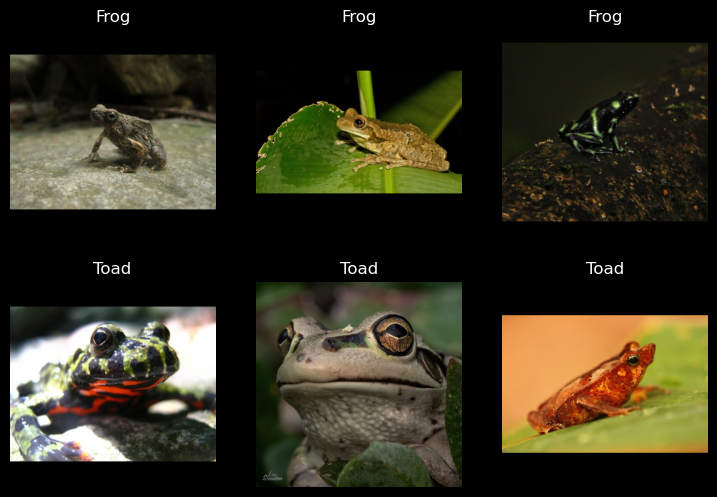

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of training images
dataiter = iter(sample_loader)
images, labels = next(dataiter)

# Function to unnormalize and plot image 
def display_images(images):

    ncols = min(3, len(images))
    nrows = 2 if len(images > 3) else 1

    # Initialize the plot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), 
                             subplot_kw={'xticks': [], 'yticks': []})
    
    # Setting the background color of the plot to black
    fig.patch.set_facecolor('black')
    
    # Make a plot for each image
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0))) 
        label = "Frog" if (labels[i].item() == 0) else "Toad"
        ax.set_title(label, color='white')
        ax.axis("off")
    
    plt.show()

# Plot the images
display_images(images)

## Model Preparation

Next, we set up our model architecture:

1. **Loading Pretrained EfficientNet**: We load a pretrained EfficientNet model which has been trained on ImageNet, a large dataset consisting of over 14 million images and 1000 classes. Leveraging a pretrained model allows us to use the features the model has already learned from a large amount of data, speeding up the learning process and enhancing performance.

2. **Freezing the Pretrained Layers**: We then freeze the pretrained layers by setting requires_grad=False. This means we will keep the weights of the pretrained layers unchanged and will only update the weights of the final classifier layers that we'll add next.

3. **Adding a Custom Classifier**: Finally, we add a new custom classifier to the model which will be trained to classify frogs and toads. This classifier consists of several layers including fully connected layers, ReLU activation functions, and a dropout layer which helps prevent overfitting.

In [3]:
from torch import nn
from torchvision.models.efficientnet import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Load the efficientnet model with the weights trained on imagenet
model = efficientnet_v2_s(EfficientNet_V2_S_Weights)

# Freeze gradient updates in pretrained layers
for param in model.parameters():
    param.requires_grad=False

# Add a custom trainable classifier on top
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=625),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 194MB/s]


## Training and Validation
Here we are setting up the training and validation process for our model:

1. **Setting up the Device**: We first set up the device that we will use for computations. If a GPU is available, we use it; otherwise, we resort to using the CPU.

2. **Defining Optimizer and Loss Function**: Next, we define our optimizer and loss function. We're using the Adam optimizer, a popular choice due to its adaptive learning rate capabilities. Our loss function is Cross-Entropy Loss, common for multi-class classification tasks.

3. **Training and Validation Loop**: We then enter our training loop. For a set number of epochs, we perform the following operations:
    - Set the model to training mode and iterate over the training dataset, loading batches of images and their corresponding labels.
    - For each batch, we clear the gradients, perform a forward pass (feeding the images through the model), calculate the loss, backpropagate the gradients and update the weights.
    - We then calculate the running loss and accuracy for the training set.
    - After training on all batches, we set the model to evaluation mode and iterate over the validation dataset, performing similar steps but without backpropagation or weight updates.
    - We store the average loss and accuracy values for both the training and validation sets for each epoch, which can be used for analysis later.

By the end of this process, our model should be trained to classify images of frogs and toads accurately.

In [6]:
from torch.optim import Adam

# Choose device based on whether a GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

# Set the optimizer (Adam optimizer)
optimizer = Adam(model.parameters())

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for
num_epochs = 3

# Place holders to store loss and accuracy values
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

# Loop over the dataset multiple times
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training phase
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward Pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        # Compute total loss
        train_running_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        print('\rEpoch: {} \tBatch: {}/{} \tRunning Loss: {:.3f}'.format(epoch+1, i+1, len(train_loader), train_running_loss/(inputs.size(0)*(i+1))), end="")

    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation phase
    valid_running_loss = 0.0
    valid_correct = 0
    valid_total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Prediction
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute total loss
            valid_running_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_epoch_loss = valid_running_loss / len(test_loader.dataset)
    valid_epoch_acc = 100 * valid_correct / valid_total
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)

    print(f'\nEpoch {epoch+1}, Train Loss: {train_epoch_loss:.2f}, Train Accuracy: {train_epoch_acc:.2f}, Valid Loss: {valid_epoch_loss:.2f}, Valid Accuracy: {valid_epoch_acc:.2f}')

print('Finished Training')

# Specify the path
model_path = "Models/efficientnet_v2_s_trained_classifier_trained_3_epochs.pt"
# Save the model
torch.save(model.state_dict(), model_path)

Epoch: 1 	Batch: 90/90 	Running Loss: 2.261
Epoch 1, Train Loss: 0.50, Train Accuracy: 74.75, Valid Loss: 0.46, Valid Accuracy: 77.85
Epoch: 2 	Batch: 90/90 	Running Loss: 1.967
Epoch 2, Train Loss: 0.43, Train Accuracy: 79.61, Valid Loss: 0.42, Valid Accuracy: 79.50
Epoch: 3 	Batch: 90/90 	Running Loss: 1.895
Epoch 3, Train Loss: 0.42, Train Accuracy: 80.11, Valid Loss: 0.44, Valid Accuracy: 79.34
Finished Training


## Convolutional Visualizations with Captum

https://captum.ai/docs/introduction.html

Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch.

With the increase in model complexity and the resulting lack of transparency, model interpretability methods have become increasingly important. Model understanding is both an active area of research as well as an area of focus for practical applications across industries using machine learning. Captum provides state-of-the-art algorithms, including Integrated Gradients, to provide researchers and developers with an easy way to understand which features are contributing to a model’s output.

We will use the LayerGradCam class in Captum to understand what specific features within an image the model is focusing on to make a decision.

In [11]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00a 0:00:01


## Grad-CAM Technique

In this part of the code, we are visualizing the activations of a specific layer of our trained model using the Gradient-weighted Class Activation Mapping (Grad-CAM) technique. This method highlights the regions in the input image that were important for the model's prediction. This can be helpful in understanding why the model made a particular prediction.

Here's a breakdown of what is happening in the visualize_cam function:

1. **Model and Layer Selection**: The model is set to evaluation mode, and the target layer of interest within the model is selected. This layer is where we want to visualize the activations.

2. **Grad-CAM Object**: A LayerGradCam object is created, which will generate a Grad-CAM for the given model and target layer.

3. **Prediction and Attribute Calculation**: The model makes a prediction for the input image, and Grad-CAM generates an activation map (heatmap) for the predicted class. This map is generated based on the gradients flowing into the target layer of the model.

4. **Normalization and Resizing**: The heatmap is converted to a numpy array, normalized to fall within the range [0, 1], and resized to match the original image size.

5. **Superimposing**: The heatmap is then superimposed onto the original image, giving a clear visualization of the areas in the image that led to the model's prediction.

6. **Plotting**: The original image, the heatmap, and the superimposed image are then plotted side by side.

7. Finally, a batch of images from the test loader is fetched, and the visualize_cam function is called to visualize the important regions for the model's prediction in the first image of the batch.

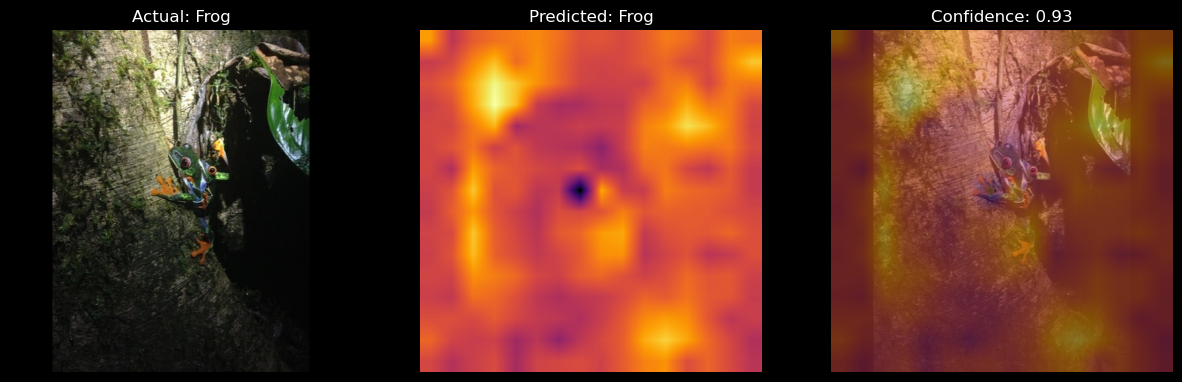

In [112]:
from captum.attr import LayerGradCam
import torch.nn.functional as F

def visualize_cam(model, image_tensor, actual_label):
    '''
    This function visualizes the GradCAM heatmap, the original image and the image superimposed with the heatmap.

    Parameters
    ----------
    model: torch.nn.Module
        The trained model.
    image_tensor: torch.Tensor
        The tensor of the image to be visualized.
    actual_label: int
        The actual label of the image. 0 for frog, 1 for toad.
    '''
    import matplotlib.cm as mpl_color_map
    from PIL import Image

    # Ensure the model is in eval mode
    model = model.eval()

    # Choose the layer for which we want to see the Grad-CAM.
    target_layer = model._modules['features'][6][14].block[3][0]

    # Create an object of LayerGradCam
    grad_cam = LayerGradCam(model, target_layer)

    # Get the prediction
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)

    # Generate Grad-CAM for the highest scoring class
    cam = grad_cam.attribute(image_tensor, predicted.item())
    cam = torch.squeeze(cam)  # remove the batch dimension

    # Convert the output of GradCam to a numpy array and normalize it to range 0-1
    cam_np = cam.cpu().detach().numpy()
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

    # Upscale the heatmap to the size of the original image
    cam_image = Image.fromarray(np.uint8(255 * cam_np))
    upscaled_cam_image = cam_image.resize((image_tensor.shape[2], image_tensor.shape[3]), Image.BILINEAR)
    upscaled_cam_np = np.array(upscaled_cam_image) / 255

    # Convert the heatmap to RGB
    heatmap = mpl_color_map.inferno_r(upscaled_cam_np)[..., :3]

    # Convert the original image to RGB
    
    # Convert to numpy format and remove extra dimensions
    original_image_np = image_tensor.cpu().numpy().squeeze()  
    
    # Change the dimensions from (3, 500, 500) to (500, 500, 3) for plotting
    original_image_rgb = np.transpose(original_image_np, (1, 2, 0))  

    # Superimpose the original image and the heatmap with a 50% opacity
    superimposed_image = original_image_rgb * 0.5 + heatmap * 0.5

    # Now we can plot all three images together
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})

    # Setting the background color of the plot to black
    fig.patch.set_facecolor('black')

    actual_label_text = "Frog" if actual_label == 0 else "Toad"
    predicted_label_text = "Frog" if predicted.item() == 0 else "Toad"

    # Apply softmax to output to get prediction scores
    pred_probabilities = F.softmax(output, dim=1)
    pred_confidence = pred_probabilities[0, predicted.item()].item()  # confidence score for the predicted class

    # Displaying original image
    axes[0].imshow(original_image_rgb)
    axes[0].set_title(f'Actual: {actual_label_text}', color='white')

    # Displaying the GradCAM heatmap
    axes[1].imshow(upscaled_cam_np, cmap='inferno_r')
    axes[1].set_title(f'Predicted: {predicted_label_text}', color='white')

    # Displaying the superimposed image
    axes[2].imshow(superimposed_image)
    axes[2].set_title(f'Confidence: {pred_confidence:.2f}', color='white')

    # Remove axes
    for ax in axes:
        ax.axis('off')

    plt.show()
    

# Get one batch of testing images for visualization
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Visualize an imamge
image_tensor = images[0].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[0])

#### Insights:
- Interestingly, the Grad-CAM visualizations reveal that the model seems to concentrate on the central portion of the image, highlighting the location of the frog's foot.
- This suggests that the model may be recognizing feet as a distinguishing feature to differentiate frogs from toads.

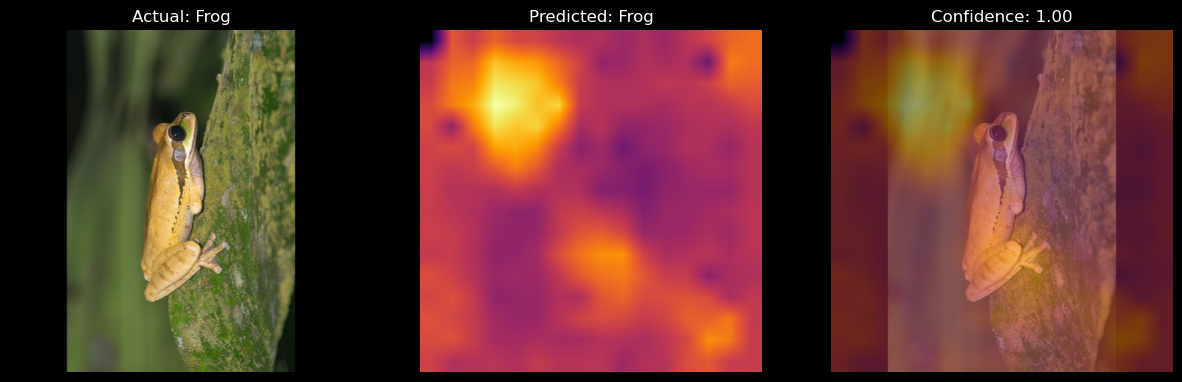

In [115]:
image_tensor = images[3].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[3])

#### Insights:
- The Grad-CAM visualization once more brings our attention to the frog's foot.
- Notably, it also emphasizes the vertical foliage in the background. This suggests the model may associate such elements with frogs, given their frequent vertical orientation - a posture rarely adopted by toads.

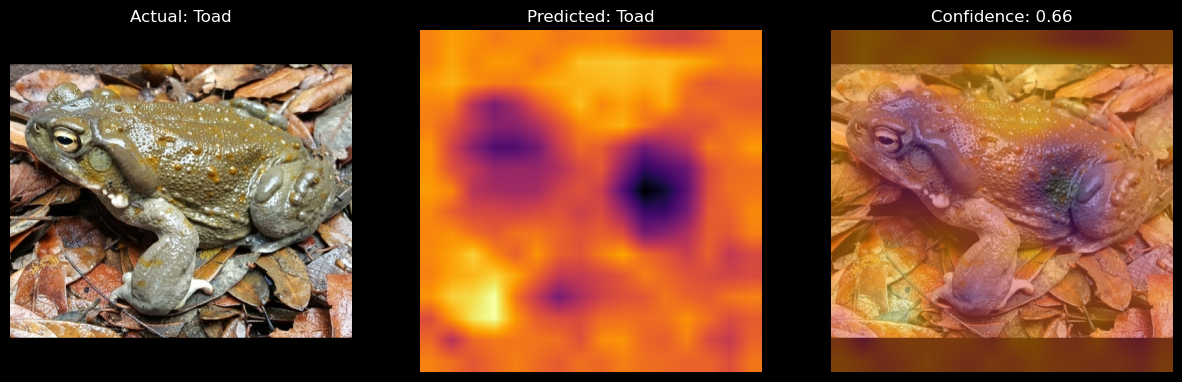

In [151]:
image_tensor = images[6].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[6])

#### Insights:
- In this instance, the Grad-CAM visualization distinctly marks both eyes, an area on the back, and the foot.
- This could indicate that the model is picking up on prominent facial features as a characteristic more commonly associated with toads.
- Additionally, the model's focus on the shorter back legs and the stubby ends of the front feet may indicate it's identifying these features as toadlike traits.

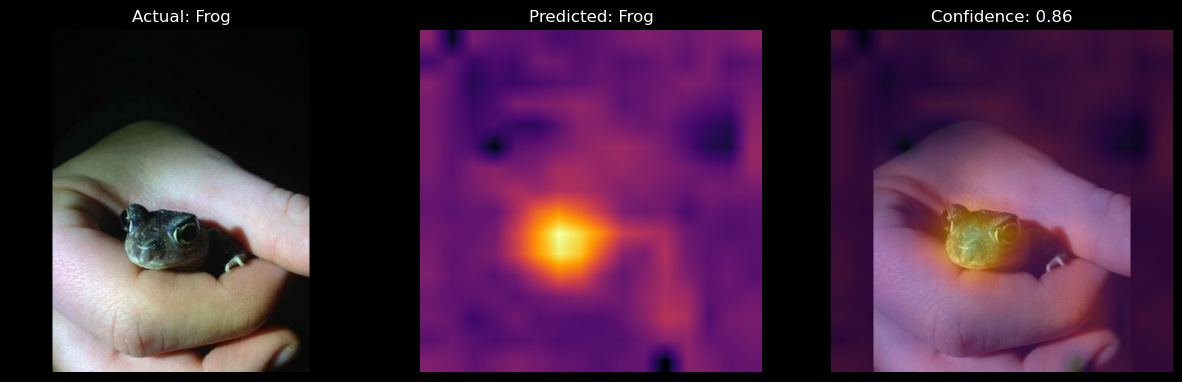

In [122]:
image_tensor = images[10].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[10])

#### Insights:
- In this case, our model appears to be significantly drawn to the facial region of the frog, specifically the snout.
- It seems that the more pointed snout of the frog could be a distinguishing feature that the model has learned to identify.

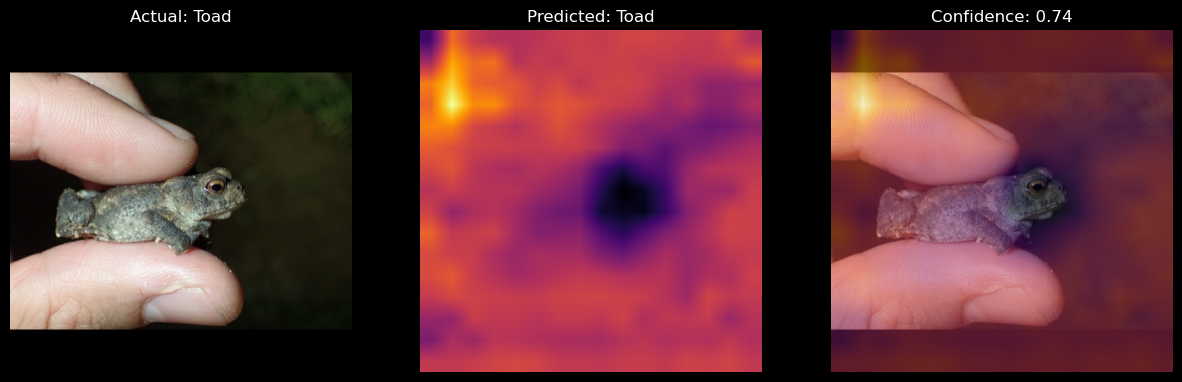

In [132]:
image_tensor = images[21].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[21])

#### Insights:
- Intriguingly, our model zeroes in on the facial area of the toad in this instance.
- The presence of human fingers might be causing a slight diversion, potentially hindering the model from recognizing the rest of the body.

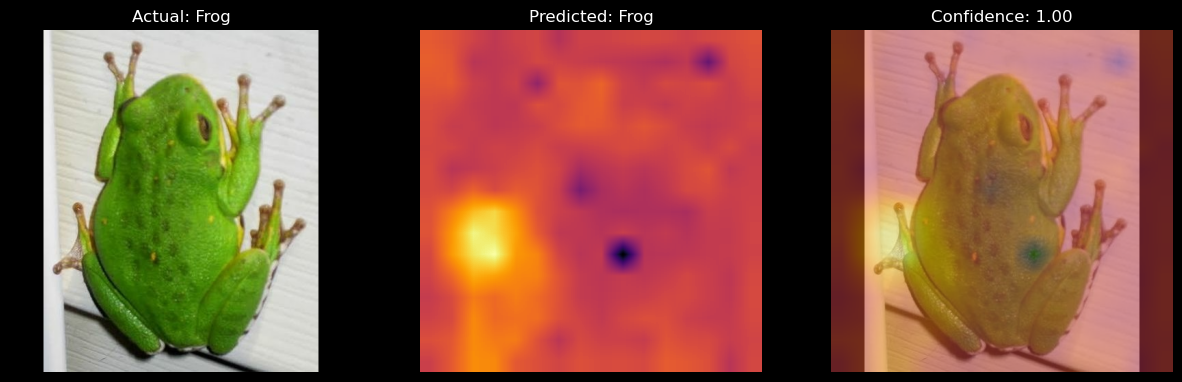

In [140]:
image_tensor = images[29].to(device).unsqueeze(0)
visualize_cam(model, image_tensor, labels[29])

#### Insights:
- Once more, the Grad-CAM effectively highlights what seems to be a distinct 'frog foot' with its characteristic bulbous tips.
- Curiously, the model seems to disregard the entirety of the image, focusing intently on just one foot.

## Conclusion and Reflections
Our model displayed the ability to highlight certain anatomical features, such as feet, facial features, and body structure, showcasing its strength in finding critical differentiators between frogs and toads. It seems that it has learned to detect subtle nuances like the more pointed snout of frogs, the distinct 'frog foot' with bulbous tips, and prominent facial features as characteristic of toads. We also saw indications that the model may consider environmental cues, like the presence of vertical foliage.

While the focus on certain areas, like the feet, was consistent, the model's occasional confusion – possibly caused by distinct fingers or other less identifiable features – serves as a valuable reminder of the challenges faced in image classification tasks.

I hope this notebook was able to highlight the utility of advanced machine learning techniques in the field of biological classification and how interpretability tools like Grad-CAM can shed light on the inner workings of these complex models, as well as nature itself.

I hope this notebook has piqued your interest in the intersection of biology and AI. Any feedback is welcome. 